In [42]:
# Basic imports
import os
import sys
import time
import timeit
import random
import pickle
import re
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold, LeaveOneOut, cross_validate, cross_val_score
)
from sklearn.linear_model import (
    LinearRegression, Lasso, LassoCV, MultiTaskLasso, MultiTaskLassoCV,
    ElasticNet, ElasticNetCV, MultiTaskElasticNet, MultiTaskElasticNetCV
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

from sklearn.cross_decomposition import PLSRegression
from sklearn.inspection import permutation_importance


# Statistic imports 
from scipy.stats import ks_2samp
from scipy.special import kl_div
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform

# Specialized imputation and visualization packages
import miceforest as mf
import missingno as msno
#from missforest import MissForest
#import magic
from src.gain import *

# Custom modules
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *
from src.wrapper import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning and machine learning specific 
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
import xgboost as xgb
import shap

# Ignore warnings
warnings.filterwarnings("ignore")

# Print CUDA availability for PyTorch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


## Load data 

In [68]:
data = load_pickle_data_palettes()

results_pickle_folder = "../pickle/"

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
dict_select = data["dict_select"]

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

# Leave-One-Complete-Out (LOCO-CV)

## All features

In [44]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

print(sum(idx_test))

print(df_all[idx_test].RID)

df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]] = df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]].astype("category")

test_indices = [i for i, val in enumerate(idx_test) if val]

13
3609    2002
5631    4167
5662    4176
5780    4215
5950    4349
6069    4292
6077    4453
6085    4489
6224    4505
6400    4576
6429    4300
7021    2374
7192    4179
Name: RID, dtype: int64


In [ ]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    #("SimpleImputer_mean", SimpleImputer(strategy="mean")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("KNNImputer_2", KNNImputer(n_neighbors=2)),
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("SimpleImputer_most_frequent", SimpleImputer(strategy="most_frequent")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("SimpleImputer_constant", SimpleImputer(strategy="constant", fill_value=-1))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
    ("MultiTaskElasticNet", MultiTaskElasticNet()),
    ("MultiTaskElasticNet_tuned", MultiTaskElasticNet(**{'alpha': 0.01, 'l1_ratio': 0.01})),
    ("MultiTaskLasso", MultiTaskLasso()),
    ("MultiTaskLasso_tuned", MultiTaskLasso(**{'alpha': 0.001})),
    ("RandomForestRegressor", RandomForestRegressor()),
    ("XGBoostRegressor", XGBoostRegressor()),
    ("XGBoostRegressor_tuned", XGBoostRegressor(**{'colsample_bytree': 0.5079831261101071, 'learning_rate': 0.0769592094304232, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8049983288913105})),
    ("TabNetRegressor_default", TabNetModelWrapper(n_a=8, n_d=8)),
    ("TabNetRegressor_custom", TabNetModelWrapper(n_a=32, n_d=32)),
    ("PLSRegression_4_components", PLSRegression(n_components=4))
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: MultiTaskElasticNet
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: MultiTaskElasticNet_tuned
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: MultiTaskLasso
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: MultiTaskLasso_tuned
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: RandomForestRegressor
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: XGBoostRegressor
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: XGBoostRegressor_tuned
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: TabNetRegressor_default
Continuous Imputer: KNNImputer, Ordinal Imputer: S

In [46]:
# Initialize HDF5 file
results_file = '../pickle/training_3_loonona_dict_results.pickle'

In [47]:
if os.path.exists(results_file): 
    with open(results_file, "rb") as input_file:
        all_dict_results = pickle.load(input_file)

else : 
    all_dict_results = []

In [48]:
for continuous_imputer, ordinal_imputer, model in combinations:
    name_continuous_imputer, continuous_imputer_instance = continuous_imputer
    name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
    name_model, model_instance = model

    params = {
            "ordinal_imputer": name_ordinal_imputer, 
            "continuous_imputer": name_continuous_imputer, 
            "model": name_model, "train_shape" : [df_X.shape[0]-1, df_X.shape[1]],
            "test_shape": [1, df_X.shape[1]]
        }
    
    # Define the subset of keys you care about
    keys_to_check = ['ordinal_imputer', 'continuous_imputer', 'model']  # or whatever subset you want

    # Check if a result in all_dict_results has the same values for just those keys
    if any(all(result['params'].get(k) == params.get(k) for k in keys_to_check) for result in all_dict_results):
        print(f"Skipping existing combination (subset match): {[params[k] for k in keys_to_check]}")
        continue

    dict_results = {
            "params": params, 
            "imputation_time": [],
            "fitting_time": [], 
            "results_adj": [], 
            "results_org": []
        }

    for test_nloc in test_indices: 
        print(test_nloc)

        idx_train = [True for i in range(df_X.shape[0])]
        idx_test = [False for i in range(df_X.shape[0])]

        idx_test[test_nloc] = True
        idx_train[test_nloc] = False

        df_X_train = df_X.loc[idx_train]
        df_X_test = df_X.loc[idx_test]

        df_y_train = df_y.loc[idx_train]
        df_y_test = df_y.loc[idx_test]

        c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
        c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

        try: 
        
            # Now you can call your `train_model` function with these components
            fold_dict_results = train_imputer_model(
                df_X_train, df_X_test, df_y_train, df_y_test,
                c_train, c_test,
                ordinal_imputer_instance, name_ordinal_imputer,
                continuous_imputer_instance, name_continuous_imputer,
                model_instance, name_model,
                separate_imputers=True  # Or however you want to specify
            )
            
            dict_results["imputation_time"].append(fold_dict_results["imputation_time"]) 
            dict_results["fitting_time"].append(fold_dict_results["fitting_time"])  
            dict_results["results_adj"].append(fold_dict_results["results_adj"])  
            dict_results["results_org"].append(fold_dict_results["results_org"])  

        except Exception as e:  

            print(e)
            
    # Optionally keep the all_dict_results list updated
    all_dict_results.append(dict_results)

    # Save the updated results back to the pickle file
    with open(results_file, 'wb') as f:
        pickle.dump(all_dict_results, f)


Skipping existing combination (subset match): ['SimpleImputer_most_frequent', 'KNNImputer', 'LinearRegression']
Skipping existing combination (subset match): ['SimpleImputer_most_frequent', 'KNNImputer', 'MultiTaskElasticNet']
1790
Using separate imputers for ordinal and continuous data.


No NaN in test data -> Keep as it is. 
The 'alpha' parameter of MultiTaskElasticNet must be a float in the range [0.0, inf). Got {'alpha': 0.01, 'l1_ratio': 0.01} instead.
2390
Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 
The 'alpha' parameter of MultiTaskElasticNet must be a float in the range [0.0, inf). Got {'alpha': 0.01, 'l1_ratio': 0.01} instead.
2401
Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 
The 'alpha' parameter of MultiTaskElasticNet must be a float in the range [0.0, inf). Got {'alpha': 0.01, 'l1_ratio': 0.01} instead.
2437
Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 
The 'alpha' parameter of MultiTaskElasticNet must be a float in the range [0.0, inf). Got {'alpha': 0.01, 'l1_ratio': 0.01} instead.
2493
Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 
The 'alpha' parameter of 

In [49]:
# Store data (serialize)
with open(results_file, 'wb') as handle:
    pickle.dump(all_dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
results_file

'../pickle/training_3_loonona_dict_results.pickle'

In [51]:
with open(results_file, "rb") as input_file:
    dict_results_loo_nona = pickle.load(input_file)

In [52]:
df_results_nona = pd.json_normalize(dict_results_loo_nona)

In [53]:
metrics = ["mse_score", "mae_score", "r2", "explained_variance", "corr"]
results = ["results_adj", "results_org"]

df_results_nona = pd.json_normalize(dict_results_loo_nona)

def extract_metric(row, metric): 

    y_test = np.concatenate([temp_dict["y_test"] for temp_dict in row])
    y_pred = np.concatenate([temp_dict["y_pred"] for temp_dict in row])

    mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(y_test=y_test, y_pred=y_pred)

    output = None

    if metric=="mse_score": 
        output=mse_score
    elif metric=="mae_score": 
        output=mae_score
    elif metric=="r2": 
        output=r2        
    elif metric=="explained_variance": 
        output=explained_variance
    elif metric=="corr": 
        output=corr   

    return list(output.T)


In [54]:
for metric in metrics: 
    df_results_nona[f"results_adj.{metric}"] = df_results_nona["results_adj"].apply(extract_metric, metric=metric)
    df_results_nona[f"results_org.{metric}"] = df_results_nona["results_org"].apply(extract_metric, metric=metric)

TypeError: 'float' object is not iterable

In [ ]:
for results in ["results_adj", "results_org"]: 
    for metric in metrics: 
        new_cols = list(f"{results}.{metric}." +df_y.columns) 
        new_cols_to_add = df_results_nona[f"{results}.{metric}"].apply(pd.Series, index=new_cols)

        df_results_nona = pd.concat([df_results_nona, new_cols_to_add], axis=1)

In [ ]:
df_results_nona.columns

Index(['imputation_time', 'fitting_time', 'results_adj', 'results_org',
       'params.ordinal_imputer', 'params.continuous_imputer', 'params.model',
       'params.train_shape', 'params.test_shape', 'results_adj.mse_score',
       'results_org.mse_score', 'results_adj.mae_score',
       'results_org.mae_score', 'results_adj.r2', 'results_org.r2',
       'results_adj.explained_variance', 'results_org.explained_variance',
       'results_adj.corr', 'results_org.corr',
       'results_adj.mse_score.ADNI_MEM', 'results_adj.mse_score.ADNI_EF',
       'results_adj.mse_score.ADNI_VS', 'results_adj.mse_score.ADNI_LAN',
       'results_adj.mae_score.ADNI_MEM', 'results_adj.mae_score.ADNI_EF',
       'results_adj.mae_score.ADNI_VS', 'results_adj.mae_score.ADNI_LAN',
       'results_adj.r2.ADNI_MEM', 'results_adj.r2.ADNI_EF',
       'results_adj.r2.ADNI_VS', 'results_adj.r2.ADNI_LAN',
       'results_adj.explained_variance.ADNI_MEM',
       'results_adj.explained_variance.ADNI_EF',
       'resul

In [ ]:
df_results_loonona_radar = df_results_nona.melt(id_vars=df_results_nona.columns[df_results_nona.columns.str.startswith("params")].tolist(), value_vars=df_results_nona.columns[df_results_nona.columns.str.contains("ADNI")].tolist())
df_results_loonona_radar["result_domain"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[0])
df_results_loonona_radar["metric"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[1])

In [ ]:
df_results_loonona_radar["cognitive_domain"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[2])
df_results_loonona_radar = df_results_loonona_radar.drop(columns=["variable"])
df_results_loonona_radar["preprocessing"] =  df_results_loonona_radar[['params.ordinal_imputer', 'params.continuous_imputer']].agg('.'.join, axis=1)

In [ ]:
df_results_loonona_radar["pipeline"] =  df_results_loonona_radar[['params.ordinal_imputer', 'params.continuous_imputer', 'params.model']].agg('.'.join, axis=1)

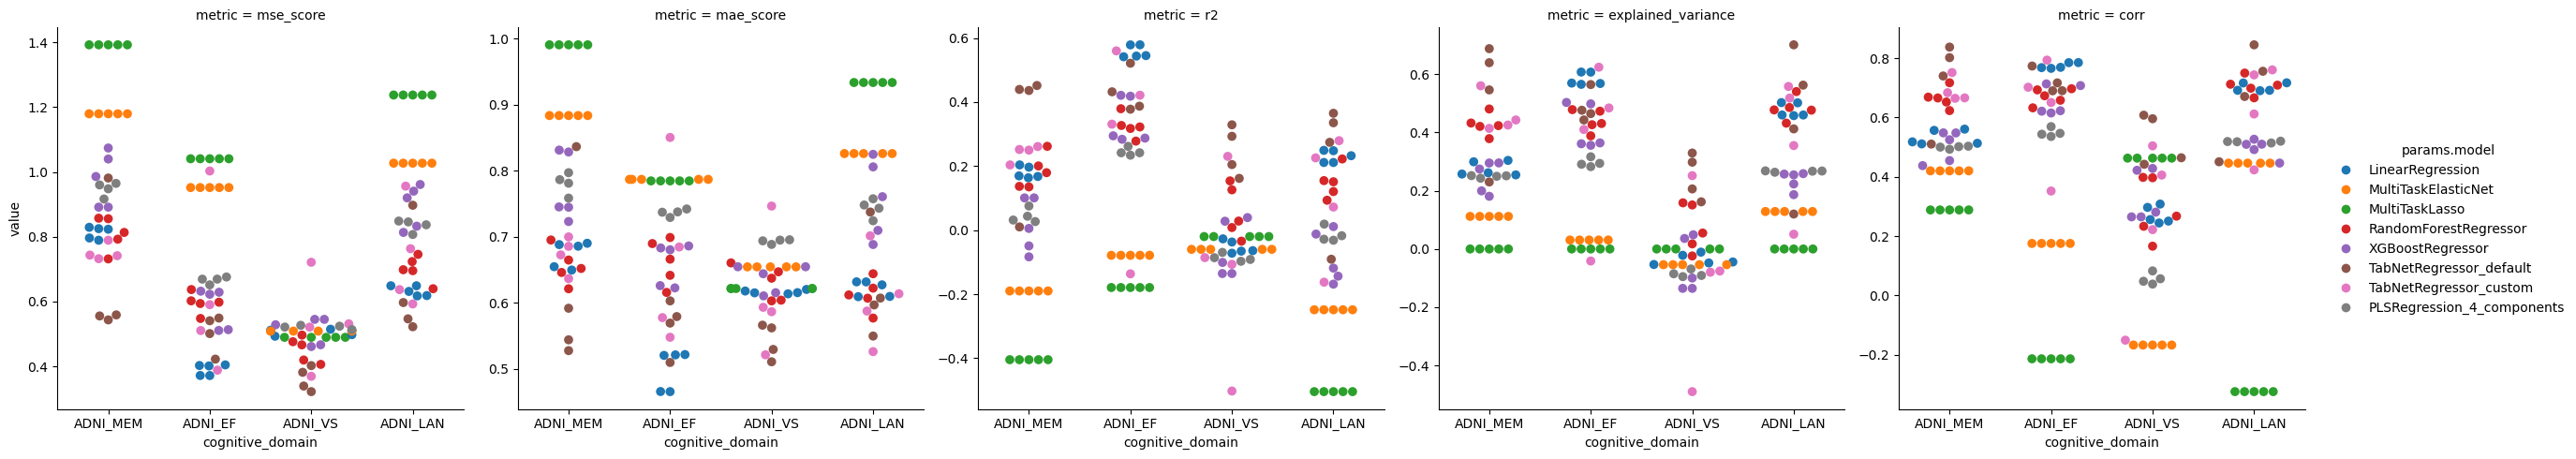

In [ ]:
df_plot_loonona_ajd = df_results_loonona_radar[df_results_loonona_radar['result_domain'] == "results_adj"]
df_plot_loonona_org = df_results_loonona_radar[df_results_loonona_radar['result_domain'] == "results_org"]

sns.catplot(data=df_plot_loonona_ajd, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

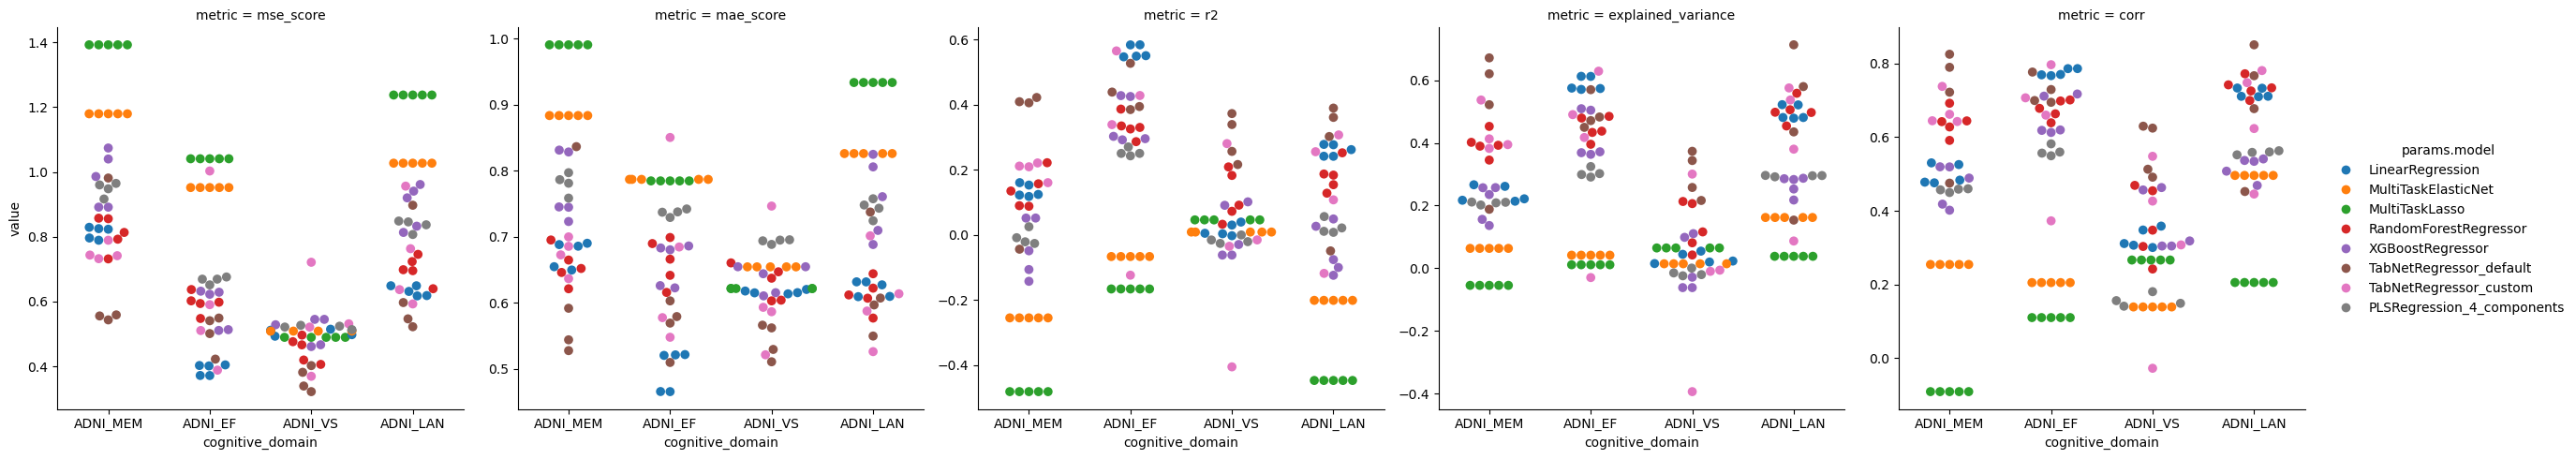

In [ ]:
sns.catplot(data=df_plot_loonona_org, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

## Train models only on MRI features to compare performances

In [72]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

In [73]:
df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]] = df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]].astype("category")

In [74]:
df_X_train = df_X[dict_select["MRIth"]].loc[idx_train]
df_X_test = df_X[dict_select["MRIth"]].loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

In [75]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("NoImputer", KNNImputer(n_neighbors=1)),

]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("NoImputer", SimpleImputer(strategy="most_frequent")),
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
    ("MultiTaskElasticNet", MultiTaskElasticNet()),
    ("MultiTaskElasticNet_tuned", MultiTaskElasticNet({'alpha': 0.01, 'l1_ratio': 0.01})),
    ("MultiTaskLasso", MultiTaskLasso()),
    ("MultiTaskLasso_tuned", MultiTaskLasso({'alpha': 0.001})),
    ("RandomForestRegressor", RandomForestRegressor()),
    ("XGBoostRegressor", XGBoostRegressor()),
    ("XGBoostRegressor_tuned", XGBoostRegressor(**{'colsample_bytree': 0.5079831261101071, 'learning_rate': 0.0769592094304232, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8049983288913105})),
    ("TabNetRegressor_default", TabNetModelWrapper(n_a=8, n_d=8)),
    ("TabNetRegressor_custom", TabNetModelWrapper(n_a=32, n_d=32)),
    ("PLSRegression_4_components", PLSRegression(n_components=4))
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: LinearRegression
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskElasticNet
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskElasticNet_tuned
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskLasso
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskLasso_tuned
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: RandomForestRegressor
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: XGBoostRegressor
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: XGBoostRegressor_tuned
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: TabNetRegressor_default
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: TabNetRegressor_custom
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: PLSRegression_4_components
Combinations of preprocessing and model

In [76]:
# Initialize HDF5 file
results_file = '../pickle/training_3_loonona_dict_results.pickle'

with open('../pickle/training_3_loonona_dict_results.pickle', "rb") as input_file:
    all_dict_results = pickle.load(input_file)

In [77]:
for continuous_imputer, ordinal_imputer, model in combinations:
    name_continuous_imputer, continuous_imputer_instance = continuous_imputer
    name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
    name_model, model_instance = model

    try: 
    
        # Now you can call your `train_model` function with these components
        dict_results = train_imputer_model(
            df_X_train, df_X_test, df_y_train, df_y_test,
            c_train, c_test,
            ordinal_imputer_instance, name_ordinal_imputer,
            continuous_imputer_instance, name_continuous_imputer,
            model_instance, name_model,
            separate_imputers=True  # Or however you want to specify
        )

    except Exception as e:  

        print(e)
    
        params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : df_X_train.shape, 
        "test_shape": df_X_test.shape
    }
        dict_results = {
        "params": params, 
        "imputation_time": None,
        "fitting_time": None, 
        "results_adj": None, 
        "results_org": None
    }
        
    # Optionally keep the all_dict_results list updated
    all_dict_results.append(dict_results)

    # Save the updated results back to the pickle file
    with open(results_file, 'wb') as f:
        pickle.dump(all_dict_results, f)


Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
The 'alpha' parameter of MultiTaskElasticNet must be a float in the range [0.0, inf). Got {'alpha': 0.01, 'l1_ratio': 0.01} instead.
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
The 'alpha' parameter of MultiTaskLasso must be a float in the range [0.0, inf). Got {'alpha': 0.001} instead.
Using separate imputers for ordinal and continuous data.
No NaN in train dat

In [78]:
# Store data (serialize)
with open(results_file, 'wb') as handle:
    pickle.dump(all_dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
with open(results_file, "rb") as input_file:
    all_dict_results = pickle.load(input_file)

In [60]:
df_results_split = missing_results_dict_to_dataframe(all_dict_results, df_y.columns)
df_results_split_radar = df_results_split.melt(id_vars=df_results_split.columns[df_results_split.columns.str.startswith("params")].tolist(), value_vars=df_results_split.columns[df_results_split.columns.str.startswith("results")].tolist())

TypeError: 'float' object is not subscriptable

In [ ]:
df_results_split_radar["variable"] = df_results_split_radar["variable"].apply(lambda x : x.replace("_ajd_", "_"))
df_results_split_radar["result_domain"] = df_results_split_radar["variable"].apply(lambda x: x.split(".")[0])
df_results_split_radar["metric"] = df_results_split_radar["variable"].apply(lambda x: "_".join(x.split(".")[1].split(".")[:2]))
df_results_split_radar["cognitive_domain"] = df_results_split_radar["variable"].apply(lambda x: "".join(x.split(".")[2]))
df_results_split_radar = df_results_split_radar.drop(columns=["variable"])
df_results_split_radar["preprocessing"] =  df_results_split_radar[['params.ordinal_imputer', 'params.continuous_imputer']].agg('.'.join, axis=1)
df_results_split_radar["pipeline"] =  df_results_split_radar[['params.ordinal_imputer', 'params.continuous_imputer', 'params.model']].agg('.'.join, axis=1)

In [ ]:
df_results_split_radar

,params.ordinal_imputer,params.continuous_imputer,params.model,params.train_shape,params.test_shape,value,result_domain,metric,cognitive_domain,preprocessing,pipeline
0,SimpleImputer_most_frequent,KNNImputer,LinearRegression,"(2882, 261)","(12, 261)",1.077550,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.LinearR...
1,SimpleImputer_most_frequent,KNNImputer,MultiTaskElasticNet,"(2882, 261)","(12, 261)",1.032492,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.MultiTa...
2,SimpleImputer_most_frequent,KNNImputer,MultiTaskLasso,"(2882, 261)","(12, 261)",1.031354,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.MultiTa...
3,SimpleImputer_most_frequent,KNNImputer,RandomForestRegressor,"(2882, 261)","(12, 261)",0.815788,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.RandomF...
4,SimpleImputer_most_frequent,KNNImputer,XGBoostRegressor,"(2882, 261)","(12, 261)",0.897634,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.XGBoost...
...,...,...,...,...,...,...,...,...,...,...,...
4235,NoImputer,NoImputer,TabNetRegressor_default,"(2882, 200)","(12, 200)",0.616612,results_org,corr,ADNI_LAN,NoImputer.NoImputer,NoImputer.NoImputer.TabNetRegressor_default
4236,NoImputer,NoImputer,TabNetRegressor_custom,"(2882, 200)","(12, 200)",0.596705,results_org,corr,ADNI_LAN,NoImputer.NoImputer,NoImputer.NoImputer.TabNetRegressor_custom
4237,NoImputer,NoImputer,PLSRegression_2_components,"(2882, 200)","(12, 200)",0.633622,results_org,corr,ADNI_LAN,NoImputer.NoImputer,NoImputer.NoImputer.PLSRegression_2_components
4238,NoImputer,NoImputer,PLSRegression_4_components,"(2882, 200)","(12, 200)",0.496479,results_org,corr,ADNI_LAN,NoImputer.NoImputer,NoImputer.NoImputer.PLSRegression_4_components


In [ ]:
def df_results_radar_to_latex_pretable(df_results_preprocess_radar_, result_domain = "results_adj", scoring_metric="corr", ascending=True): 
        
        df_results_preprocess_to_latex = df_results_preprocess_radar_.drop(columns=["preprocessing", "params.train_shape", "params.test_shape"])

        df = df_results_preprocess_to_latex[df_results_preprocess_to_latex["result_domain"]== result_domain].drop(columns="result_domain")

        df_pivoted = df.pivot_table(index=['params.ordinal_imputer', 'params.continuous_imputer', 'params.model'],
                                    columns=['metric', 'cognitive_domain'],
                                    values='value',
                                    aggfunc='first')

        # Resetting index to flatten the MultiIndex
        df_pivoted.reset_index(inplace=True)
        # Flatten the MultiIndex columns temporarily for filtering
        df_pivoted.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df_pivoted.columns]

        # Select columns that start with 'params' or contain 'corr'
        columns_to_keep = [col for col in df_pivoted.columns if col.startswith('params') or scoring_metric in col]

        # Filter the dataframe
        df_filtered = df_pivoted[columns_to_keep]

        # Display the filtered dataframe
        # Add a column for the mean of each row
        # Select only the numeric columns (excluding 'params' columns)
        numeric_columns = df_filtered.select_dtypes(include='number').columns

        # Add a column for the mean of each row (across numeric columns)
        df_filtered['mean'] = df_filtered[numeric_columns].mean(axis=1)

        # Add a column for the standard deviation of each row (across numeric columns)
        df_filtered['std'] = df_filtered[numeric_columns].std(axis=1)

        return df_filtered.sort_values("mean", ascending=ascending)

In [ ]:
pd.set_option('display.float_format', '{:.3f}'.format)
df_results_radar_to_latex_pretable(df_results_split_radar, result_domain="results_adj", scoring_metric="corr", ascending=False).dropna()

,params.ordinal_imputer_,params.continuous_imputer_,params.model_,corr_ADNI_EF,corr_ADNI_LAN,corr_ADNI_MEM,corr_ADNI_VS,mean,std
74,SimpleImputer_most_frequent,KNNImputer_2,TabNetRegressor_default,0.792,0.774,0.844,0.603,0.753,0.105
9,KNNImputer,KNNImputer,TabNetRegressor_default,0.737,0.637,0.766,0.723,0.716,0.056
42,SimpleImputer_constant,KNNImputer,XGBoostRegressor,0.792,0.622,0.634,0.598,0.662,0.088
40,SimpleImputer_constant,KNNImputer,TabNetRegressor_custom,0.750,0.700,0.679,0.515,0.661,0.102
20,KNNImputer,KNNImputer_2,TabNetRegressor_default,0.684,0.712,0.759,0.487,0.660,0.119
...,...,...,...,...,...,...,...,...,...
26,NoImputer,NoImputer,PLSRegression_2_components,0.360,0.612,0.567,-0.148,0.348,0.348
27,NoImputer,NoImputer,PLSRegression_4_components,0.515,0.454,0.414,0.005,0.347,0.232
19,KNNImputer,KNNImputer_2,TabNetRegressor_custom,0.047,0.556,0.403,0.265,0.318,0.216
62,SimpleImputer_most_frequent,KNNImputer,TabNetRegressor_custom,0.345,0.211,0.443,0.028,0.257,0.180


In [ ]:
pd.set_option('display.float_format', '{:.3f}'.format)
df_results_radar_to_latex_pretable(df_results_split_radar, result_domain="results_adj", scoring_metric="mae_score", ascending=True)

,params.ordinal_imputer_,params.continuous_imputer_,params.model_,mae_score_ADNI_EF,mae_score_ADNI_LAN,mae_score_ADNI_MEM,mae_score_ADNI_VS,mean,std
9,KNNImputer,KNNImputer,TabNetRegressor_default,0.487,0.685,0.615,0.383,0.543,0.134
20,KNNImputer,KNNImputer_2,TabNetRegressor_default,0.598,0.574,0.603,0.536,0.578,0.031
74,SimpleImputer_most_frequent,KNNImputer_2,TabNetRegressor_default,0.533,0.630,0.662,0.499,0.581,0.077
40,SimpleImputer_constant,KNNImputer,TabNetRegressor_custom,0.636,0.583,0.689,0.499,0.602,0.081
42,SimpleImputer_constant,KNNImputer,XGBoostRegressor,0.564,0.632,0.673,0.540,0.602,0.061
...,...,...,...,...,...,...,...,...,...
62,SimpleImputer_most_frequent,KNNImputer,TabNetRegressor_custom,0.825,0.835,0.828,0.642,0.782,0.094
73,SimpleImputer_most_frequent,KNNImputer_2,TabNetRegressor_custom,0.783,0.791,0.833,0.755,0.790,0.033
8,KNNImputer,KNNImputer,TabNetRegressor_custom,0.890,0.738,0.769,0.799,0.799,0.066
23,NoImputer,NoImputer,MultiTaskElasticNet,0.837,0.926,0.974,0.625,0.840,0.154


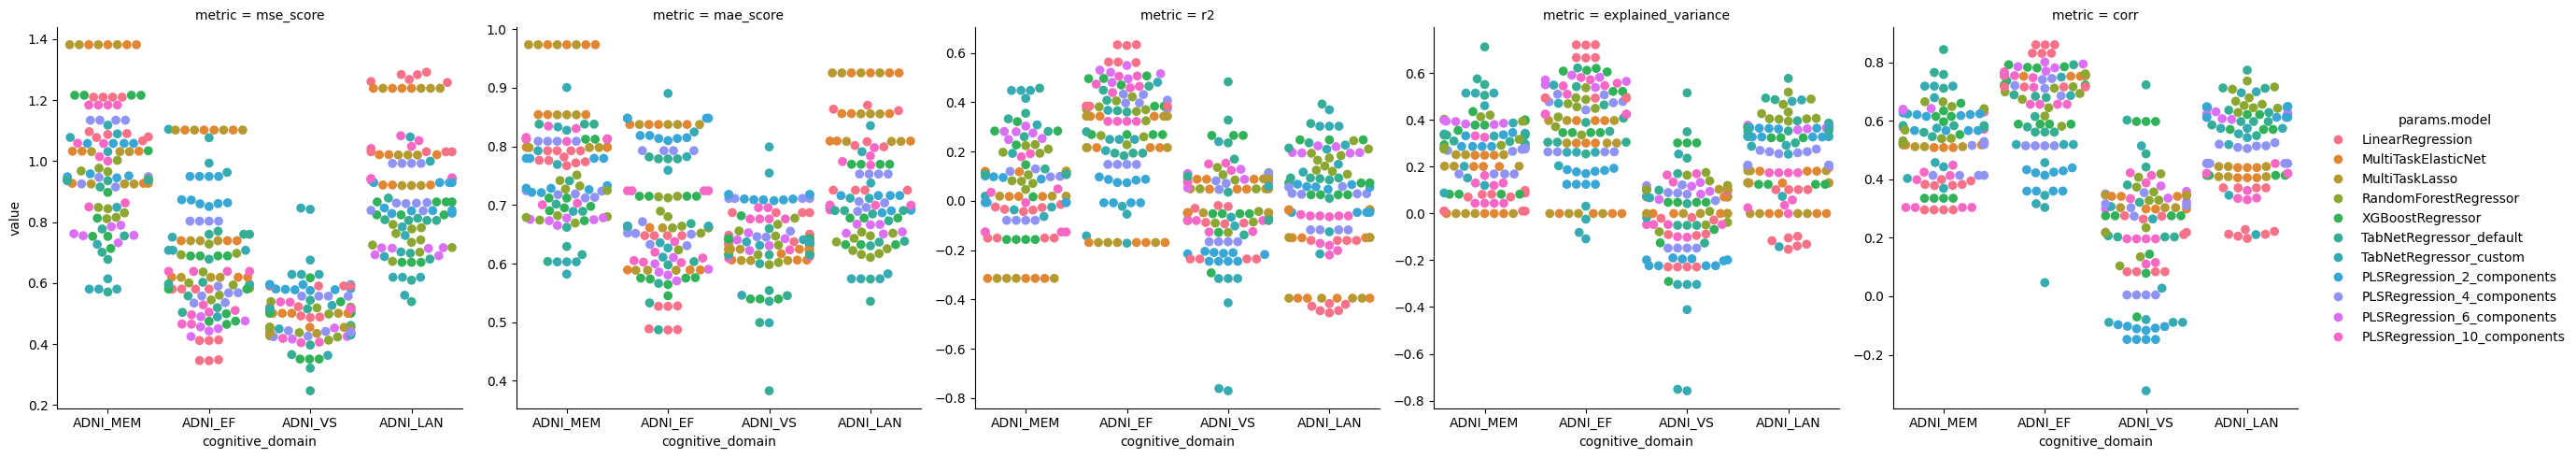

In [ ]:
df_plot_split_ajd = df_results_split_radar[df_results_split_radar['result_domain'] == "results_adj"]
df_plot_split_org = df_results_split_radar[df_results_split_radar['result_domain'] == "results_org"]

sns.catplot(data=df_plot_split_ajd, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

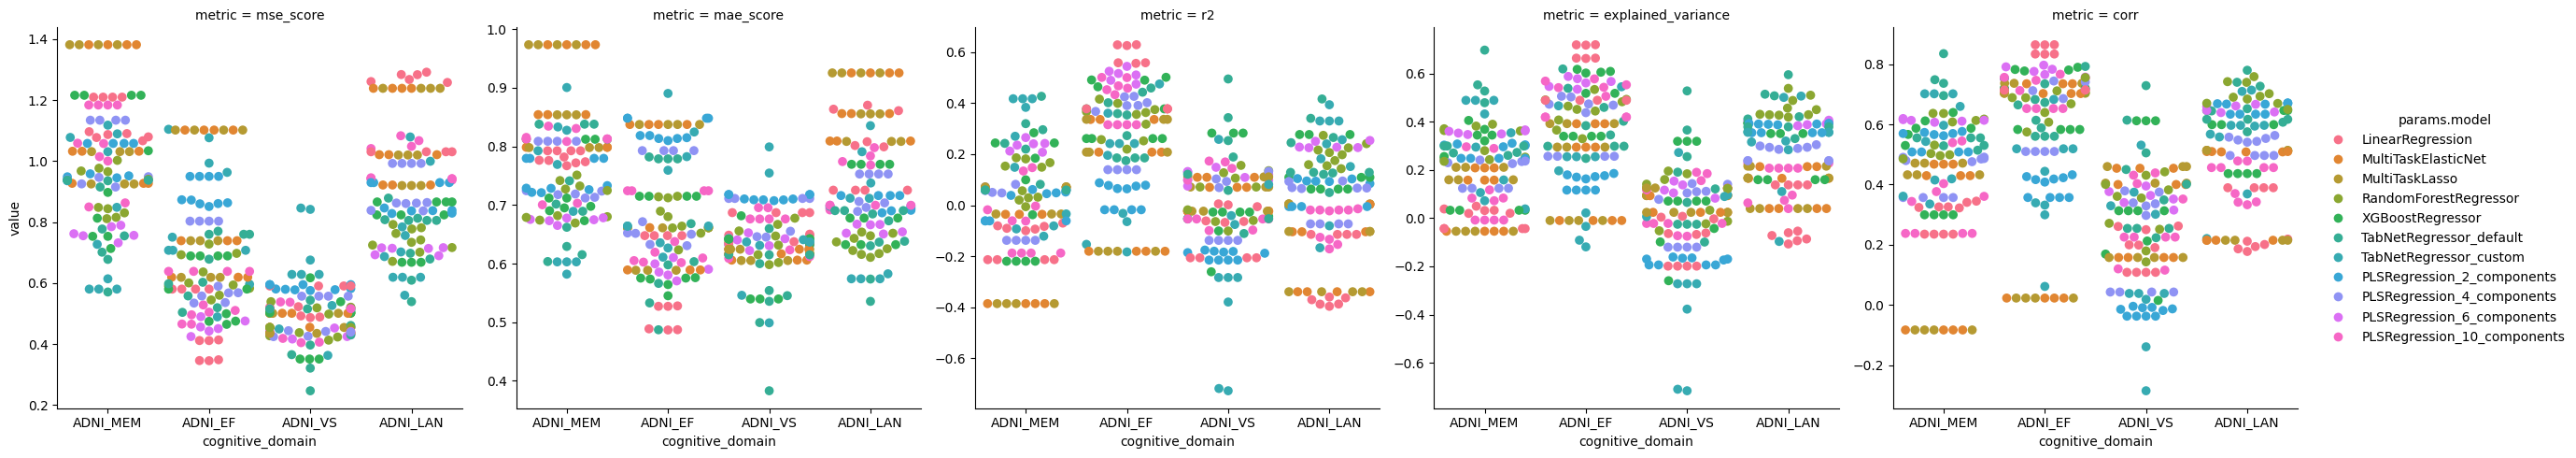

In [ ]:
sns.catplot(data=df_plot_split_org, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

## Print Table for paper

In [ ]:
with open('..pickle//training_3_loonona_dict_results.pickle', "rb") as input_file:
    dict_results_loo_nona = pickle.load(input_file)

In [ ]:
df_results_nona = pd.json_normalize(dict_results_loo_nona)

In [ ]:
metrics = ["mse_score", "mae_score", "r2", "explained_variance", "corr"]
results = ["results_adj", "results_org"]

df_results_nona = pd.json_normalize(dict_results_loo_nona)

def extract_metric(row, metric): 

    y_test = np.concatenate([temp_dict["y_test"] for temp_dict in row])
    y_pred = np.concatenate([temp_dict["y_pred"] for temp_dict in row])

    mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(y_test=y_test, y_pred=y_pred)

    output = None

    if metric=="mse_score": 
        output=mse_score
    elif metric=="mae_score": 
        output=mae_score
    elif metric=="r2": 
        output=r2        
    elif metric=="explained_variance": 
        output=explained_variance
    elif metric=="corr": 
        output=corr   

    return list(output.T)


In [ ]:
for metric in metrics: 
    df_results_nona[f"results_adj.{metric}"] = df_results_nona["results_adj"].apply(extract_metric, metric=metric)
    df_results_nona[f"results_org.{metric}"] = df_results_nona["results_org"].apply(extract_metric, metric=metric)

In [ ]:
for results in ["results_adj", "results_org"]: 
    for metric in metrics: 
        new_cols = list(f"{results}.{metric}." +df_y.columns) 
        new_cols_to_add = df_results_nona[f"{results}.{metric}"].apply(pd.Series, index=new_cols)

        df_results_nona = pd.concat([df_results_nona, new_cols_to_add], axis=1)

In [ ]:
df_results_nona.columns

Index(['imputation_time', 'fitting_time', 'results_adj', 'results_org',
       'params.ordinal_imputer', 'params.continuous_imputer', 'params.model',
       'params.train_shape', 'params.test_shape', 'results_adj.mse_score',
       'results_org.mse_score', 'results_adj.mae_score',
       'results_org.mae_score', 'results_adj.r2', 'results_org.r2',
       'results_adj.explained_variance', 'results_org.explained_variance',
       'results_adj.corr', 'results_org.corr',
       'results_adj.mse_score.ADNI_MEM', 'results_adj.mse_score.ADNI_EF',
       'results_adj.mse_score.ADNI_VS', 'results_adj.mse_score.ADNI_LAN',
       'results_adj.mae_score.ADNI_MEM', 'results_adj.mae_score.ADNI_EF',
       'results_adj.mae_score.ADNI_VS', 'results_adj.mae_score.ADNI_LAN',
       'results_adj.r2.ADNI_MEM', 'results_adj.r2.ADNI_EF',
       'results_adj.r2.ADNI_VS', 'results_adj.r2.ADNI_LAN',
       'results_adj.explained_variance.ADNI_MEM',
       'results_adj.explained_variance.ADNI_EF',
       'resul

In [ ]:
df_results_loonona_radar = df_results_nona.melt(id_vars=df_results_nona.columns[df_results_nona.columns.str.startswith("params")].tolist(), value_vars=df_results_nona.columns[df_results_nona.columns.str.contains("ADNI")].tolist())
df_results_loonona_radar["result_domain"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[0])
df_results_loonona_radar["metric"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[1])

In [ ]:
df_results_loonona_radar["cognitive_domain"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[2])
df_results_loonona_radar = df_results_loonona_radar.drop(columns=["variable"])
df_results_loonona_radar["preprocessing"] =  df_results_loonona_radar[['params.ordinal_imputer', 'params.continuous_imputer']].agg('.'.join, axis=1)

In [ ]:
df_results_loonona_radar["pipeline"] =  df_results_loonona_radar[['params.ordinal_imputer', 'params.continuous_imputer', 'params.model']].agg('.'.join, axis=1)

In [ ]:
df_results_loonona_radar

,params.ordinal_imputer,params.continuous_imputer,params.model,params.train_shape,params.test_shape,value,result_domain,metric,cognitive_domain,preprocessing,pipeline
0,SimpleImputer_most_frequent,KNNImputer,LinearRegression,"[2882, 261]","[12, 261]",1.088,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.LinearR...
1,SimpleImputer_most_frequent,KNNImputer,MultiTaskElasticNet,"[2893, 261]","[1, 261]",1.037,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.MultiTa...
2,SimpleImputer_most_frequent,KNNImputer,MultiTaskLasso,"[2893, 261]","[1, 261]",1.036,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.MultiTa...
3,SimpleImputer_most_frequent,KNNImputer,RandomForestRegressor,"[2893, 261]","[1, 261]",0.762,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.RandomF...
4,SimpleImputer_most_frequent,KNNImputer,XGBoostRegressor,"[2893, 261]","[1, 261]",0.894,results_adj,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,SimpleImputer_most_frequent.KNNImputer.XGBoost...
...,...,...,...,...,...,...,...,...,...,...,...
1715,NoImputer,NoImputer,TabNetRegressor_default,"(2893, 200)","(1, 200)",0.522,results_org,corr,ADNI_LAN,NoImputer.NoImputer,NoImputer.NoImputer.TabNetRegressor_default
1716,NoImputer,NoImputer,TabNetRegressor_custom,"(2893, 200)","(1, 200)",0.410,results_org,corr,ADNI_LAN,NoImputer.NoImputer,NoImputer.NoImputer.TabNetRegressor_custom
1717,NoImputer,NoImputer,PLSRegression_2_components,"(2893, 200)","(1, 200)",0.633,results_org,corr,ADNI_LAN,NoImputer.NoImputer,NoImputer.NoImputer.PLSRegression_2_components
1718,NoImputer,NoImputer,PLSRegression_4_components,"(2893, 200)","(1, 200)",0.498,results_org,corr,ADNI_LAN,NoImputer.NoImputer,NoImputer.NoImputer.PLSRegression_4_components


In [ ]:
df_results_radar_to_latex_pretable(df_results_loonona_radar, result_domain="results_adj", scoring_metric="corr", ascending=False)

,params.ordinal_imputer_,params.continuous_imputer_,params.model_,corr_ADNI_EF,corr_ADNI_LAN,corr_ADNI_MEM,corr_ADNI_VS,mean,std
30,SimpleImputer_constant,KNNImputer,TabNetRegressor_default,0.797,0.802,0.901,0.476,0.744,0.185
9,KNNImputer,KNNImputer,TabNetRegressor_default,0.709,0.739,0.763,0.585,0.699,0.079
40,SimpleImputer_most_frequent,KNNImputer,TabNetRegressor_custom,0.872,0.775,0.672,0.465,0.696,0.174
39,SimpleImputer_most_frequent,KNNImputer,RandomForestRegressor,0.746,0.760,0.723,0.445,0.669,0.150
7,KNNImputer,KNNImputer,RandomForestRegressor,0.699,0.725,0.736,0.383,0.636,0.169
28,SimpleImputer_constant,KNNImputer,RandomForestRegressor,0.705,0.657,0.679,0.421,0.616,0.131
27,SimpleImputer_constant,KNNImputer,PLSRegression_6_components,0.788,0.615,0.629,0.360,0.598,0.177
38,SimpleImputer_most_frequent,KNNImputer,PLSRegression_6_components,0.775,0.632,0.638,0.329,0.593,0.188
8,KNNImputer,KNNImputer,TabNetRegressor_custom,0.714,0.786,0.717,0.153,0.592,0.295
6,KNNImputer,KNNImputer,PLSRegression_6_components,0.764,0.626,0.632,0.303,0.581,0.196


In [ ]:
df_results_radar_to_latex_pretable(df_results_loonona_radar, result_domain="results_adj", scoring_metric="mae_score", ascending=True)

,params.ordinal_imputer_,params.continuous_imputer_,params.model_,mae_score_ADNI_EF,mae_score_ADNI_LAN,mae_score_ADNI_MEM,mae_score_ADNI_VS,mean,std
30,SimpleImputer_constant,KNNImputer,TabNetRegressor_default,0.490,0.411,0.377,0.504,0.445,0.062
40,SimpleImputer_most_frequent,KNNImputer,TabNetRegressor_custom,0.445,0.441,0.622,0.519,0.507,0.085
9,KNNImputer,KNNImputer,TabNetRegressor_default,0.604,0.613,0.619,0.528,0.591,0.043
39,SimpleImputer_most_frequent,KNNImputer,RandomForestRegressor,0.615,0.571,0.620,0.573,0.595,0.026
8,KNNImputer,KNNImputer,TabNetRegressor_custom,0.540,0.605,0.639,0.687,0.618,0.062
41,SimpleImputer_most_frequent,KNNImputer,TabNetRegressor_default,0.732,0.521,0.663,0.574,0.622,0.093
28,SimpleImputer_constant,KNNImputer,RandomForestRegressor,0.626,0.638,0.644,0.589,0.624,0.025
7,KNNImputer,KNNImputer,RandomForestRegressor,0.671,0.603,0.624,0.611,0.627,0.030
27,SimpleImputer_constant,KNNImputer,PLSRegression_6_components,0.576,0.662,0.675,0.625,0.635,0.044
38,SimpleImputer_most_frequent,KNNImputer,PLSRegression_6_components,0.593,0.653,0.674,0.639,0.640,0.035


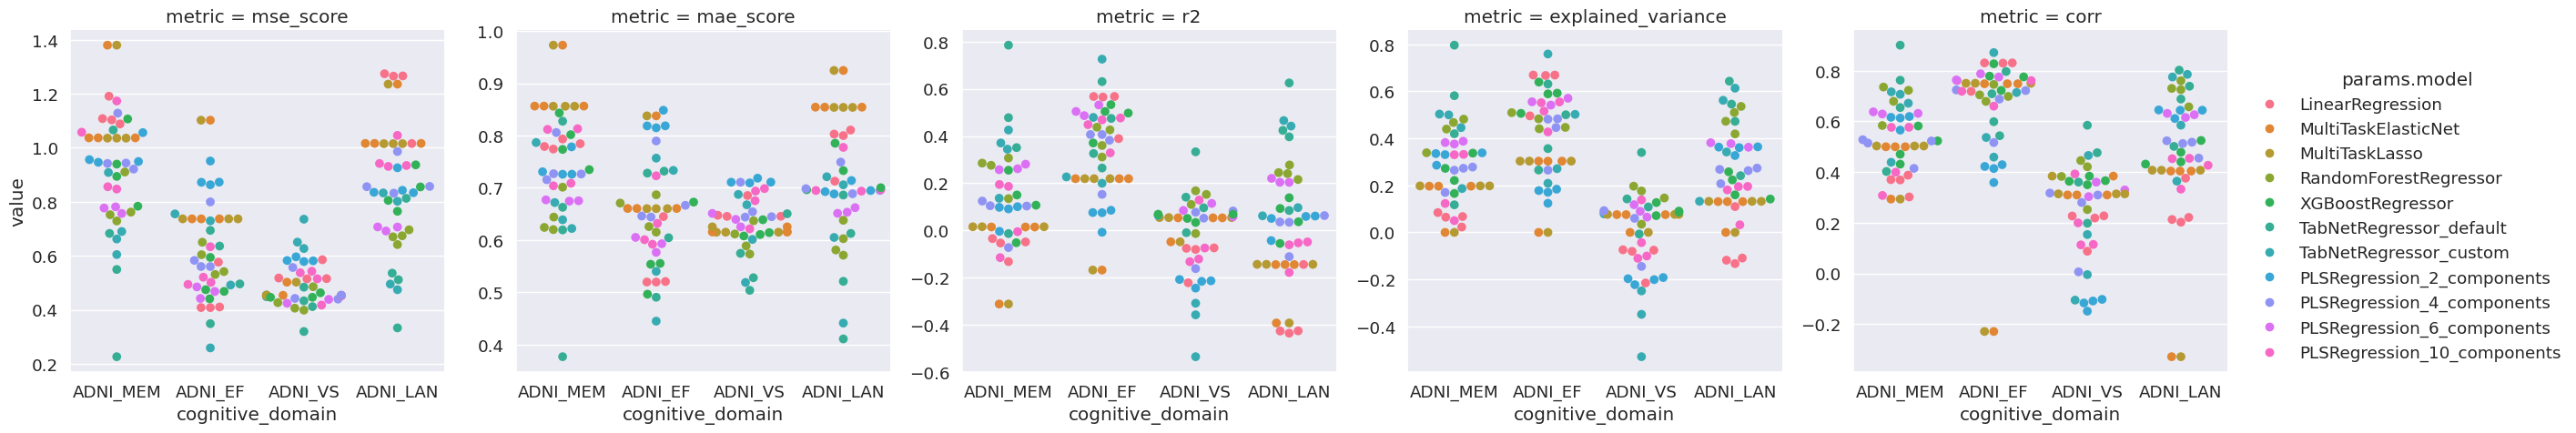

In [ ]:
df_plot_loonona_ajd = df_results_loonona_radar[df_results_loonona_radar['result_domain'] == "results_adj"]
df_plot_loonona_org = df_results_loonona_radar[df_results_loonona_radar['result_domain'] == "results_org"]

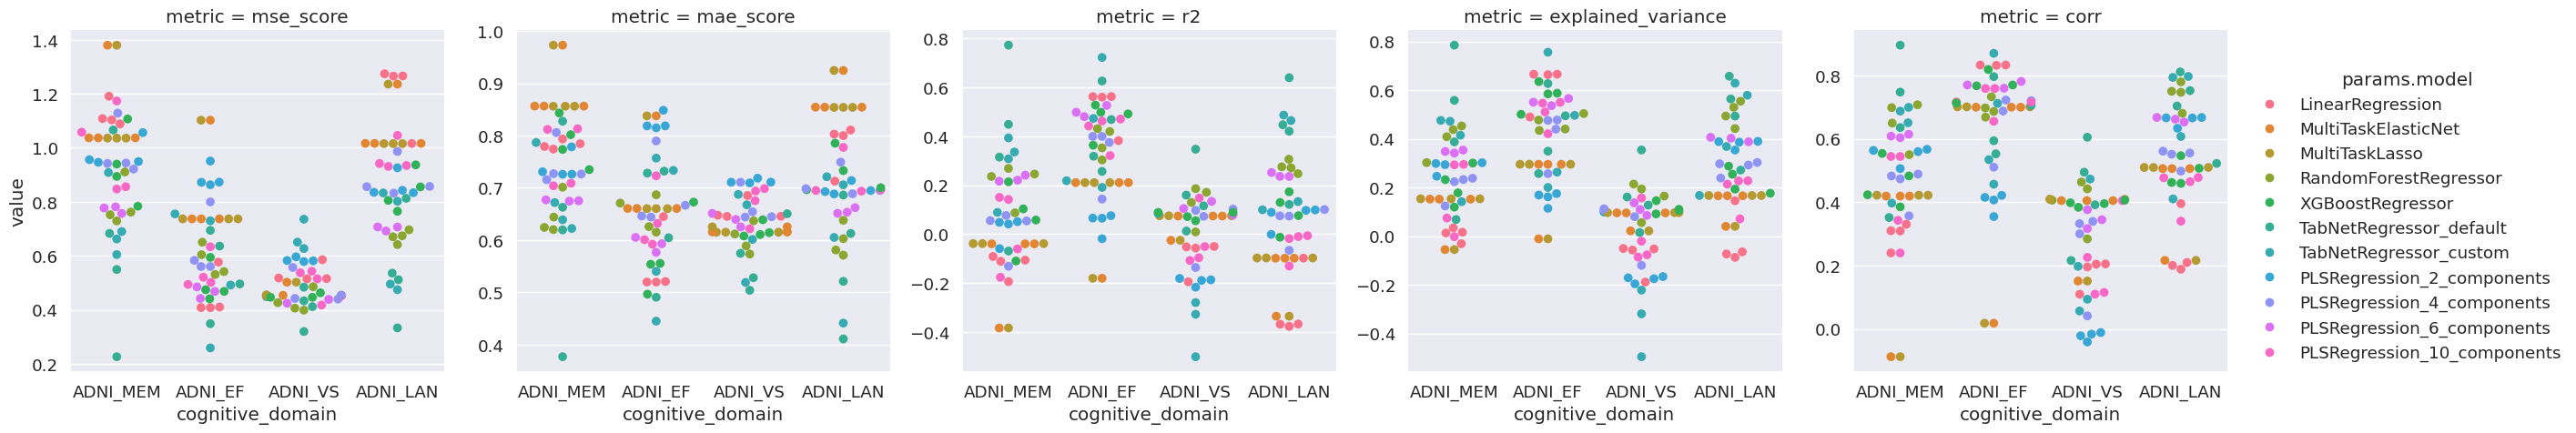

In [ ]:
sns.catplot(data=df_plot_loonona_org, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

In [ ]:
len(dict_results_loo_nona)

43

In [ ]:
df_results_nona = pd.json_normalize(dict_results_loo_nona)

In [ ]:
metrics = ["mse_score", "mae_score", "r2", "explained_variance", "corr"]
results = ["results_adj", "results_org"]

df_results_nona = pd.json_normalize(dict_results_loo_nona)

def extract_metric(row, metric): 

    y_test = np.concatenate([temp_dict["y_test"] for temp_dict in row])
    y_pred = np.concatenate([temp_dict["y_pred"] for temp_dict in row])

    mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(y_test=y_test, y_pred=y_pred)

    output = None

    if metric=="mse_score": 
        output=mse_score
    elif metric=="mae_score": 
        output=mae_score
    elif metric=="r2": 
        output=r2        
    elif metric=="explained_variance": 
        output=explained_variance
    elif metric=="corr": 
        output=corr   

    return list(output.T)


In [ ]:
for metric in metrics: 
    df_results_nona[f"results_adj.{metric}"] = df_results_nona["results_adj"].apply(extract_metric, metric=metric)
    df_results_nona[f"results_org.{metric}"] = df_results_nona["results_org"].apply(extract_metric, metric=metric)

In [ ]:
for results in ["results_adj", "results_org"]: 
    for metric in metrics: 
        new_cols = list(f"{results}.{metric}." +df_y.columns) 
        new_cols_to_add = df_results_nona[f"{results}.{metric}"].apply(pd.Series, index=new_cols)

        df_results_nona = pd.concat([df_results_nona, new_cols_to_add], axis=1)

In [ ]:
df_results_nona.columns

Index(['imputation_time', 'fitting_time', 'results_adj', 'results_org',
       'params.ordinal_imputer', 'params.continuous_imputer', 'params.model',
       'params.train_shape', 'params.test_shape', 'params.test_rid',
       'results_adj.mse_score', 'results_org.mse_score',
       'results_adj.mae_score', 'results_org.mae_score', 'results_adj.r2',
       'results_org.r2', 'results_adj.explained_variance',
       'results_org.explained_variance', 'results_adj.corr',
       'results_org.corr', 'results_adj.mse_score.ADNI_MEM',
       'results_adj.mse_score.ADNI_EF', 'results_adj.mse_score.ADNI_VS',
       'results_adj.mse_score.ADNI_LAN', 'results_adj.mae_score.ADNI_MEM',
       'results_adj.mae_score.ADNI_EF', 'results_adj.mae_score.ADNI_VS',
       'results_adj.mae_score.ADNI_LAN', 'results_adj.r2.ADNI_MEM',
       'results_adj.r2.ADNI_EF', 'results_adj.r2.ADNI_VS',
       'results_adj.r2.ADNI_LAN', 'results_adj.explained_variance.ADNI_MEM',
       'results_adj.explained_variance.ADNI

In [ ]:
df_results_loonona_radar = df_results_nona.melt(id_vars=df_results_nona.columns[df_results_nona.columns.str.startswith("params")].tolist(), value_vars=df_results_nona.columns[df_results_nona.columns.str.contains("ADNI")].tolist())
df_results_loonona_radar["result_domain"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[0])
df_results_loonona_radar["metric"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[1])

In [ ]:
df_results_loonona_radar["cognitive_domain"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[2])
df_results_loonona_radar = df_results_loonona_radar.drop(columns=["variable"])
df_results_loonona_radar["preprocessing"] =  df_results_loonona_radar[['params.ordinal_imputer', 'params.continuous_imputer']].agg('.'.join, axis=1)

In [ ]:
df_results_loonona_radar["pipeline"] =  df_results_loonona_radar[['params.ordinal_imputer', 'params.continuous_imputer', 'params.model']].agg('.'.join, axis=1)

In [ ]:
df_results_radar_to_latex_pretable(df_results_loonona_radar, result_domain="results_adj", scoring_metric="corr", ascending=False)

,params.ordinal_imputer_,params.continuous_imputer_,params.model_,corr_ADNI_EF,corr_ADNI_LAN,corr_ADNI_MEM,corr_ADNI_VS,mean,std
30,SimpleImputer_constant,KNNImputer,TabNetRegressor_default,0.402,0.692,0.679,0.194,0.492,0.240
40,SimpleImputer_most_frequent,KNNImputer,TabNetRegressor_custom,0.529,0.828,0.493,-0.013,0.459,0.349
7,KNNImputer,KNNImputer,RandomForestRegressor,0.378,0.701,0.717,0.033,0.457,0.323
39,SimpleImputer_most_frequent,KNNImputer,RandomForestRegressor,0.392,0.727,0.754,-0.054,0.455,0.377
31,SimpleImputer_constant,KNNImputer,XGBoostRegressor,0.591,0.707,0.708,-0.197,0.452,0.436
9,KNNImputer,KNNImputer,TabNetRegressor_default,0.487,0.668,0.620,-0.008,0.441,0.310
17,NoImputer,NoImputer,RandomForestRegressor,0.433,0.760,0.682,-0.115,0.440,0.395
20,NoImputer,NoImputer,XGBoostRegressor,0.478,0.669,0.703,-0.093,0.439,0.368
28,SimpleImputer_constant,KNNImputer,RandomForestRegressor,0.408,0.719,0.695,-0.086,0.434,0.374
36,SimpleImputer_most_frequent,KNNImputer,PLSRegression_2_components,0.380,0.671,0.628,-0.022,0.414,0.318


In [ ]:
df_results_radar_to_latex_pretable(df_results_loonona_radar, result_domain="results_adj", scoring_metric="mae_score", ascending=True)

,params.ordinal_imputer_,params.continuous_imputer_,params.model_,mae_score_ADNI_EF,mae_score_ADNI_LAN,mae_score_ADNI_MEM,mae_score_ADNI_VS,mean,std
20,NoImputer,NoImputer,XGBoostRegressor,0.530,0.459,0.473,0.572,0.509,0.052
39,SimpleImputer_most_frequent,KNNImputer,RandomForestRegressor,0.629,0.450,0.425,0.551,0.514,0.094
17,NoImputer,NoImputer,RandomForestRegressor,0.594,0.423,0.490,0.549,0.514,0.074
7,KNNImputer,KNNImputer,RandomForestRegressor,0.644,0.458,0.452,0.524,0.520,0.089
28,SimpleImputer_constant,KNNImputer,RandomForestRegressor,0.596,0.444,0.480,0.565,0.521,0.071
31,SimpleImputer_constant,KNNImputer,XGBoostRegressor,0.578,0.437,0.507,0.566,0.522,0.065
25,SimpleImputer_constant,KNNImputer,PLSRegression_2_components,0.606,0.488,0.499,0.547,0.535,0.054
15,NoImputer,NoImputer,PLSRegression_2_components,0.621,0.480,0.497,0.545,0.536,0.063
36,SimpleImputer_most_frequent,KNNImputer,PLSRegression_2_components,0.609,0.491,0.497,0.547,0.536,0.055
30,SimpleImputer_constant,KNNImputer,TabNetRegressor_default,0.622,0.444,0.521,0.559,0.537,0.074
